In [ ]:
# outcome probability model for fastballs

In [2]:
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import mysql.connector
import pybaseball
from sklearn.metrics import accuracy_score, confusion_matrix

In [167]:
# load in 2022 mlb season data

df = pd.read_csv(r'C:\Users\adam.bloebaum\.vscode\driveline\2022_MLB_Season.csv')

# load in 2023 mlb season data

df_2023 = pd.read_csv(r"C:\Users\adam.bloebaum\.vscode\driveline\2023_MLB_Season.csv")

In [168]:
linear_weights = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\linear_weights.csv")

In [169]:
xpfx_x = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\2022&3_pfx_x_predictions.csv")
xpfx_z = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\2022&3_pfx_z_predictions.csv")
xspin_axis = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\2022&3_spin_axis_predictions.csv")
xswing = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\2022&3_swing_predictions.csv")
xwhiff = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\2022&3_whiff_predictions.csv")
xfb = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\2022&3_fb_predictions.csv")
xgb = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\2022&3_gb_predictions.csv")
xld = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\2022&3_ld_predictions.csv")

In [170]:
print(xpfx_x.columns)
print(xpfx_z.columns)
print(xspin_axis.columns)
print(xswing.columns)
print(xwhiff.columns)
print(xfb.columns)
print(xgb.columns)
print(xld.columns)

Index(['pitch_id_raw', 'pfx_x_cor', 'pfx_x_cor_predicted', 'pfx_x_cor_diff',
       'pfx_x_cor_diff_abs'],
      dtype='object')
Index(['pitch_id_raw', 'pfx_z', 'pfx_z_predicted', 'pfx_z_diff',
       'pfx_z_diff_abs'],
      dtype='object')
Index(['pitch_id_raw', 'spin_axis', 'spin_axis_predicted', 'spin_axis_diff',
       'spin_axis_diff_abs', 'arm_slot', 'height_ratio'],
      dtype='object')
Index(['pitcher', 'player_name', 'pitch_id_raw', 'pitch_type_condensed',
       'xswing', 'vx0', 'vy0', 'ax', 'az', 'spin_axis', 'release_speed',
       'release_pos_z', 'swing', 'release_pos_x', 'pfx_z', 'pfx_x',
       'release_spin_rate', 'height_ratio', 'arm_slot', 'swing_predicted'],
      dtype='object')
Index(['pitcher', 'player_name', 'pitch_id_raw', 'pitch_type_condensed',
       'xwhiff', 'vx0', 'vy0', 'ax', 'az', 'spin_axis', 'release_speed',
       'release_pos_z', 'whiff', 'release_pos_x', 'pfx_z', 'pfx_x',
       'release_spin_rate', 'height_ratio', 'arm_slot', 'whiff_predicted'],

In [171]:
xpfx_z.rename(columns={'pfx_z': 'pfx_z_cor'}, inplace=True)
xpfx_z.rename(columns={'pfx_z_predicted': 'pfx_z_cor_predicted'}, inplace=True)
xpfx_z.rename(columns={'pfx_z_diff': 'pfx_z_cor_diff'}, inplace=True)
xpfx_z.rename(columns={'pfx_z_diff_abs': 'pfx_z_cor_diff_abs'}, inplace=True)

xspin_axis.rename(columns={'spin_axis': 'spin_axis_cor'}, inplace=True)

xswing = xswing[['pitch_id_raw', 'swing_predicted']]
xwhiff = xwhiff[['pitch_id_raw', 'whiff_predicted']]

xfb = xfb[['pitch_id_raw', 'fb_predicted']]
xgb = xgb[['pitch_id_raw', 'xgb']]
xld = xld[['pitch_id_raw', 'ld_predicted']]

In [172]:
print(xswing.columns)
print(xwhiff.columns)
print(xfb.columns)
print(xgb.columns)
print(xld.columns)

Index(['pitch_id_raw', 'swing_predicted'], dtype='object')
Index(['pitch_id_raw', 'whiff_predicted'], dtype='object')
Index(['pitch_id_raw', 'fb_predicted'], dtype='object')
Index(['pitch_id_raw', 'xgb'], dtype='object')
Index(['pitch_id_raw', 'ld_predicted'], dtype='object')


In [173]:
# ensure df is sequential

df.sort_values(by=['game_pk', 'inning', 'at_bat_number', 'pitch_number'], inplace=True)

# convert batter handedness columns to binary

stand_encoder = LabelEncoder()
all_stand = pd.concat([df['stand'], df_2023['stand']]).unique()
stand_encoder.fit(all_stand)

df['stand'] = stand_encoder.transform(df['stand'])

# generate unique id column

df['pitch_id_raw'] = df['game_pk'].astype(str) + "_" + \
                            df['batter'].astype(str) + "_" + \
                            df['pitcher'].astype(str) + "_" + \
                            df['pitch_number'].astype(str) + "_" + \
                            df['at_bat_number'].astype(str) + "_" + \
                            df['inning'].astype(str)

# select only fastballs

df = df[df['pitch_type'].isin(['FF', 'SI', 'FC', 'FA', 'FT'])]

# normalize LHP values to RHP standards

df.loc[df['p_throws'] == 'L', 'pfx_x'] = df['pfx_x'] * -1
df.loc[df['p_throws'] == 'L', 'release_pos_x'] = df['release_pos_x'] * -1
df['spin_axis'] = 360 - df['spin_axis']

# total movement column

df['pfx_total'] = abs(df['pfx_x']) + abs(df['pfx_z'])

# movement ratio column

df['pfx_x_ratio'] = abs(df['pfx_x']) / df['pfx_total']
df['pfx_z_ratio'] = abs(df['pfx_z']) / df['pfx_total']

In [174]:
# ensure df is sequential

df_2023.sort_values(by=['game_pk', 'inning', 'at_bat_number', 'pitch_number'], inplace=True)

# convert batter handedness columns to binary

df_2023['stand'] = stand_encoder.transform(df_2023['stand'])

# generate unique id column

df_2023['pitch_id_raw'] = df_2023['game_pk'].astype(str) + "_" + \
                            df_2023['batter'].astype(str) + "_" + \
                            df_2023['pitcher'].astype(str) + "_" + \
                            df_2023['pitch_number'].astype(str) + "_" + \
                            df_2023['at_bat_number'].astype(str) + "_" + \
                            df_2023['inning'].astype(str)

# select only fastballs

df_2023 = df_2023[df_2023['pitch_type'].isin(['FF', 'SI', 'FC', 'FA', 'FT'])]

# normalize LHP values to RHP standards

df_2023.loc[df_2023['p_throws'] == 'L', 'pfx_x'] = df_2023['pfx_x'] * -1
df_2023.loc[df_2023['p_throws'] == 'L', 'release_pos_x'] = df_2023['release_pos_x'] * -1
df_2023['spin_axis'] = 360 - df['spin_axis']

# total movement column

df_2023['pfx_total'] = abs(df_2023['pfx_x']) + abs(df_2023['pfx_z'])

# movement ratio column

df_2023['pfx_x_ratio'] = abs(df_2023['pfx_x']) / df_2023['pfx_total']
df_2023['pfx_z_ratio'] = abs(df_2023['pfx_z']) / df_2023['pfx_total']

In [175]:
df[['pitch_id_raw', 'pitch_type']].head()

,pitch_id_raw,pitch_type
21296,661032_664702_663776_1_1_1,FF
21295,661032_664702_663776_2_1_1,FF
21292,661032_642708_663776_1_2_1,FF
21289,661032_608070_663776_2_3_1,FF
21287,661032_621493_663474_1_4_1,FF


In [176]:
print(linear_weights)
print(df['description'].unique())
print(df['events'].unique())

    Unnamed: 0         description  linear_weight
0            0                ball       0.046350
1            1  caught_stealing_2b      -0.246377
2            2              double       0.753249
3            3         double_play      -0.773110
4            4           field_out      -0.217943
5            5                foul      -0.037243
6            6            home_run       1.368162
7            7              single       0.467429
8            8              strike      -0.052630
9            9           strikeout      -0.215231
10          10              triple       1.097815
11          11                walk       0.236323
['ball' 'called_strike' 'foul' 'hit_into_play' 'swinging_strike'
 'foul_tip' 'hit_by_pitch' 'blocked_ball' 'missed_bunt' 'foul_bunt'
 'swinging_strike_blocked' 'bunt_foul_tip']
[nan 'field_out' 'double' 'single' 'walk' 'strikeout' 'hit_by_pitch'
 'home_run' 'force_out' 'caught_stealing_2b' 'grounded_into_double_play'
 'sac_fly' 'field_error' 'doubl

In [177]:
# create outcome column using events and description columns

events_mapping = {
    'field_out': 'field_out',
    'force_out': 'field_out',
    'fields_choice_out': 'field_out',
    'fielders_choice': 'field_out',
    'other_out': 'field_out',
    'sac_fly': 'field_out',
    'sac_bunt': 'field_out',
    'walk': 'walk',
    'hit_by_pitch': 'walk',
    'strikeout': 'strikeout',
    'grounded_into_double_play': 'double_play',
    'double_play': 'double_play',
    'strikeout_double_play': 'double_play',
    'sac_fly_double_play': 'double_play',
    'single': 'single',
    'double': 'double',
    'triple': 'triple',
    'home_run': 'home_run'    
}


description_mapping = {
    'ball': 'ball',
    'called_strike': 'strike',
    'foul': 'foul',
    #'hit_into_play': 'hit_into_play',
    'swinging_strike': 'strike',
    'foul_tip': 'foul',
    'hit_by_pitch': 'walk',
    'blocked_ball': 'ball' ,
    'missed_bunt': 'strike',
    'foul_bunt': 'foul',
    'swinging_strike_blocked': 'strike',
    'bunt_foul_tip': 'foul'
}

In [178]:
def determine_outcome(row):
    
    event = row['events']
    description = row['description']
    
    if event in events_mapping:
        return events_mapping[event]

    elif description in description_mapping:
        return description_mapping[description]

    else:
        return np.nan

# Apply the function to each row
df['outcome'] = df.apply(determine_outcome, axis=1)
df_2023['outcome'] = df_2023.apply(determine_outcome, axis=1)

In [179]:
print(df['outcome'].unique())
print(df_2023['outcome'].unique())
print(df.shape)
print(df_2023.shape)

['ball' 'strike' 'foul' 'field_out' 'double' 'single' 'walk' 'strikeout'
 'home_run' 'double_play' nan 'triple']
['strike' 'foul' 'ball' 'single' 'double_play' 'field_out' 'strikeout'
 'home_run' 'double' 'walk' 'triple' nan]
(410504, 98)
(405495, 98)


In [180]:
df.dropna(subset=['outcome'], inplace=True)
df_2023.dropna(subset=['outcome'], inplace=True)

In [181]:
print(df['outcome'].unique())
print(df_2023['outcome'].unique())
print(df.shape)
print(df_2023.shape)

['ball' 'strike' 'foul' 'field_out' 'double' 'single' 'walk' 'strikeout'
 'home_run' 'double_play' 'triple']
['strike' 'foul' 'ball' 'single' 'double_play' 'field_out' 'strikeout'
 'home_run' 'double' 'walk' 'triple']
(409730, 98)
(404804, 98)


In [182]:
outcome_encoder = LabelEncoder()

all_outcome = pd.concat([df['outcome'], df_2023['outcome']]).unique()
outcome_encoder.fit(all_outcome)

df['outcome'] = outcome_encoder.transform(df['outcome'])
df_2023['outcome'] = outcome_encoder.transform(df_2023['outcome'])

In [183]:
print(df['outcome'].unique())
print(df_2023['outcome'].unique())
print(df.shape)
print(df_2023.shape)

[ 0  7  4  3  1  6 10  8  5  2  9]
[ 7  4  0  6  2  3  8  5  1 10  9]
(409730, 98)
(404804, 98)


In [184]:
# Perform the left joins

df = pd.merge(df, xpfx_x, on='pitch_id_raw', how='left')
df = pd.merge(df, xpfx_z, on='pitch_id_raw', how='left')
df = pd.merge(df, xspin_axis, on='pitch_id_raw', how='left')
df = pd.merge(df, xswing, on='pitch_id_raw', how='left')
df = pd.merge(df, xwhiff, on='pitch_id_raw', how='left')

df = pd.merge(df, xfb, on='pitch_id_raw', how='left')
df = pd.merge(df, xgb, on='pitch_id_raw', how='left')
df = pd.merge(df, xld, on='pitch_id_raw', how='left')


# Perform the left joins

df_2023 = pd.merge(df_2023, xpfx_x, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xpfx_z, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xspin_axis, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xswing, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xwhiff, on='pitch_id_raw', how='left')

df_2023 = pd.merge(df_2023, xfb, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xgb, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xld, on='pitch_id_raw', how='left')

In [185]:
df.head()

,Unnamed: 0,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,...,spin_axis_predicted,spin_axis_diff,spin_axis_diff_abs,arm_slot,height_ratio,swing_predicted,whiff_predicted,fb_predicted,xgb,ld_predicted
0,4506,FF,2022-04-26,94.7,-1.92,6.24,"Sandoval, Patrick",664702,663776,NaN,...,147.440369,-1.440369,146.0,2.0,0.998400,-0.047741,0.013600,NaN,NaN,NaN
1,4343,FF,2022-04-26,94.6,-1.77,6.15,"Sandoval, Patrick",664702,663776,NaN,...,145.370850,9.629150,155.0,2.0,0.984000,0.455372,0.080129,NaN,NaN,NaN
2,3942,FF,2022-04-26,95.3,-1.86,6.08,"Sandoval, Patrick",642708,663776,NaN,...,148.666397,1.333603,150.0,2.0,0.972800,0.577270,0.116989,NaN,NaN,NaN
3,3532,FF,2022-04-26,95.8,-1.83,6.04,"Sandoval, Patrick",608070,663776,NaN,...,145.784531,0.215469,146.0,2.0,0.966400,0.632070,0.099975,NaN,NaN,NaN
4,4440,FF,2022-04-26,90.6,-1.94,6.53,"McKenzie, Triston",621493,663474,NaN,...,197.278915,-5.278915,192.0,2.0,1.017134,0.536083,0.069873,NaN,NaN,NaN


In [186]:
df_2023.head()

,Unnamed: 0,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,...,spin_axis_predicted,spin_axis_diff,spin_axis_diff_abs,arm_slot,height_ratio,swing_predicted,whiff_predicted,fb_predicted,xgb,ld_predicted
0,4267,FF,2023-10-01,89.6,-1.32,6.19,"Greinke, Zack",518934,425844,NaN,...,201.875046,5.124954,207.0,2.0,1.003241,0.568532,0.072008,NaN,NaN,NaN
1,4144,SI,2023-10-01,89.9,-1.44,6.10,"Greinke, Zack",518934,425844,NaN,...,209.675064,4.324936,214.0,2.0,0.988655,0.577148,0.052146,NaN,NaN,NaN
2,4092,SI,2023-10-01,90.8,-1.15,6.14,"Greinke, Zack",518934,425844,NaN,...,212.272507,-41.272507,171.0,2.0,0.995138,0.629327,0.064721,NaN,NaN,NaN
3,3985,FC,2023-10-01,84.6,-1.07,6.32,"Greinke, Zack",518934,425844,NaN,...,97.987053,28.012947,126.0,3.0,1.024311,0.499900,0.198154,NaN,NaN,NaN
4,3833,SI,2023-10-01,91.9,-1.17,6.16,"Greinke, Zack",518934,425844,NaN,...,216.893036,6.106964,223.0,2.0,0.998379,0.183062,0.024962,NaN,NaN,NaN


In [187]:
xgb.head()

,pitch_id_raw,xgb
0,663364_455139_617228_4_75_10,0.353464
1,663364_596059_518489_6_68_9,0.457407
2,663364_669720_518489_3_67_9,0.314268
3,663364_608700_605347_3_66_9,0.693035
4,663364_666915_605347_2_65_9,0.512124


In [147]:
df.loc[df['swing_predicted'] < 0, 'swing_predicted'] = 0
df_2023.loc[df_2023['swing_predicted'] < 0, 'swing_predicted'] = 0

In [98]:
df['swing_whiff'] = df['swing_predicted'] * df['whiff_predicted']
df_2023['swing_whiff'] = df_2023['swing_predicted'] * df_2023['whiff_predicted']

In [113]:
# feature selection and data splitting

# took out predicted swing and swing_whiff to see if it changed anything

features = ['release_speed', 'release_pos_x', 'release_pos_y', 'release_pos_z', 'release_extension', 'release_spin_rate', 'pfx_total', 'pfx_x_ratio', 'pfx_z_ratio', 'pfx_x_cor', 'pfx_x_cor_predicted', 'pfx_x_cor_diff', 'pfx_x_cor_diff_abs', 'pfx_z_cor', 'pfx_z_cor_predicted', 'pfx_z_cor_diff_abs', 'spin_axis_cor', 'spin_axis_predicted', 'spin_axis_diff', 'spin_axis_diff_abs', 'arm_slot', 'height_ratio', 'whiff_predicted']

# copy and keep only features

df_2023_features = df_2023[features]

# create features and targets

X = df[features]
y = df['outcome']

# train valid test split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [114]:
print(X_train.columns)

Index(['release_speed', 'release_pos_x', 'release_pos_y', 'release_pos_z',
       'release_extension', 'release_spin_rate', 'pfx_total', 'pfx_x_ratio',
       'pfx_z_ratio', 'pfx_x_cor', 'pfx_x_cor_predicted', 'pfx_x_cor_diff',
       'pfx_x_cor_diff_abs', 'pfx_z_cor', 'pfx_z_cor_predicted',
       'pfx_z_cor_diff_abs', 'spin_axis_cor', 'spin_axis_predicted',
       'spin_axis_diff', 'spin_axis_diff_abs', 'arm_slot', 'height_ratio',
       'whiff_predicted'],
      dtype='object')


In [115]:
# set up model

model = xgb.XGBClassifier(objective='multi:softmax', num_class=11, eval_metric='mlogloss', use_label_encoder=False)

# train model

model.fit(X_train, y_train)

c:\Users\adam.bloebaum\AppData\Local\miniconda3\envs\driveline\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_class=11, num_parallel_tree=None, objective='multi:softmax', ...)

In [116]:
# make predictions

y_pred = model.predict(X_valid)

# evaluate the model

accuracy = accuracy_score(y_valid, y_pred)
conf_matrix = confusion_matrix(y_valid, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')

Accuracy: 0.3440070290191101
Confusion Matrix:
[[15644     0     0    37  5747     0     1  3773    15     0     3]
 [  377     0     0     2   362     0     0   250     1     0     0]
 [  190     0     0     3   155     0     0   109     1     0     0]
 [ 3485     0     0    30  3590     0     1  2270     2     0     0]
 [ 5890     0     0    35  7679     0     5  3769    19     0     0]
 [  219     0     0     0   267     0     0   165     0     0     0]
 [ 1268     0     0     5  1254     0     1   758     3     0     0]
 [ 7345     0     0    44  6100     1     2  4825    11     0     0]
 [ 1546     0     0     5  1647     0     1   696    11     0     0]
 [   27     0     0     0    30     0     0    13     0     0     0]
 [ 1466     0     0     6   444     0     0   341     0     0     0]]


<Figure size 1000x5000 with 0 Axes>

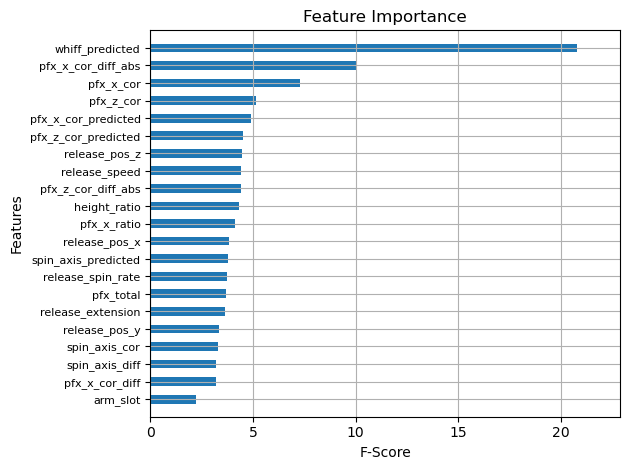

In [117]:
plt.figure(figsize=(10, 50))  # You may adjust this if needed
xgb.plot_importance(model, importance_type='gain', show_values=False, height=0.5)
plt.title('Feature Importance')
plt.xlabel('F-Score')
plt.ylabel('Features')
plt.yticks(fontsize=8)  # You can adjust fontsize if the labels are too crowded
plt.tight_layout()  # Adjust the layout to fit all labels and titles
plt.savefig('feature_importance_fb.png', dpi=300)  # Save with high resolution
plt.show()

In [118]:
# get feature importance dictionary

importance = model.get_booster().get_score(importance_type='gain')

# sort features by importance

sorted_importance = sorted(importance.items(), key=lambda item: item[1], reverse=True)

# loop to print

for feature, score in sorted_importance:
    print(f'{feature}: {score}')

whiff_predicted: 20.78838348388672
pfx_x_cor_diff_abs: 10.033320426940918
pfx_x_cor: 7.267877578735352
pfx_z_cor: 5.142052173614502
pfx_x_cor_predicted: 4.898741245269775
pfx_z_cor_predicted: 4.529703140258789
release_pos_z: 4.467822551727295
release_speed: 4.4086809158325195
pfx_z_cor_diff_abs: 4.408133029937744
height_ratio: 4.321001052856445
pfx_x_ratio: 4.129318714141846
release_pos_x: 3.8403093814849854
spin_axis_predicted: 3.8030707836151123
release_spin_rate: 3.718580961227417
pfx_total: 3.6723082065582275
release_extension: 3.6470298767089844
release_pos_y: 3.3344738483428955
spin_axis_cor: 3.2957944869995117
spin_axis_diff: 3.206692934036255
pfx_x_cor_diff: 3.1785824298858643
arm_slot: 2.2211251258850098


In [119]:
# generate outcome probabilities on 2023 mlb season data

outcome_probabilities = model.predict_proba(df_2023_features)

# apply outcome probabilities back onto full df

for i, class_label in enumerate(model.classes_):
    df_2023[f'prob_{class_label}'] = outcome_probabilities[:, i]

In [106]:
label_mapping = dict(zip(outcome_encoder.classes_, outcome_encoder.transform(outcome_encoder.classes_)))
print(label_mapping)

{'ball': 0, 'double': 1, 'double_play': 2, 'field_out': 3, 'foul': 4, 'home_run': 5, 'single': 6, 'strike': 7, 'strikeout': 8, 'triple': 9, 'walk': 10}


In [107]:
print(linear_weights)

    Unnamed: 0         description  linear_weight
0            0                ball       0.046350
1            1  caught_stealing_2b      -0.246377
2            2              double       0.753249
3            3         double_play      -0.773110
4            4           field_out      -0.217943
5            5                foul      -0.037243
6            6            home_run       1.368162
7            7              single       0.467429
8            8              strike      -0.052630
9            9           strikeout      -0.215231
10          10              triple       1.097815
11          11                walk       0.236323


In [ ]:
# for each outcome columns: mean rv of outcome * outcome probability
# aggregate by pitcher and pitch type
# rank

In [120]:
linear_weights = linear_weights[linear_weights['description'] != 'caught_stealing_2b']
linear_weights['outcome'] = outcome_encoder.transform(linear_weights['description'])
print(linear_weights)

    Unnamed: 0  description  linear_weight  outcome
0            0         ball       0.046350        0
2            2       double       0.753249        1
3            3  double_play      -0.773110        2
4            4    field_out      -0.217943        3
5            5         foul      -0.037243        4
6            6     home_run       1.368162        5
7            7       single       0.467429        6
8            8       strike      -0.052630        7
9            9    strikeout      -0.215231        8
10          10       triple       1.097815        9
11          11         walk       0.236323       10


In [121]:
linear_weight_values = linear_weights.set_index('outcome')['linear_weight']

# Now perform the weighted sum
df_2023['pitch_quality'] = sum(
    df_2023[f'prob_{i}'] * linear_weight_values[i] for i in range(11)
)

In [122]:
grouped_data = df_2023.groupby(['player_name', 'pitch_type']).filter(lambda x: len(x) > 50)

# Group the DataFrame by 'player_name' and 'pitch_type' and sum the 'pitch_quality'
pitch_quality_sum = grouped_data.groupby(['player_name', 'pitch_type'])['pitch_quality'].mean().reset_index()

# Sort the results by 'pitch_quality' in descending order and take the top 10
top_10 = pitch_quality_sum.sort_values(by='pitch_quality', ascending=False).head(10)

# Sort the results by 'pitch_quality' in ascending order and take the bottom 10
bottom_10 = pitch_quality_sum.sort_values(by='pitch_quality', ascending=True).head(10)

# Print the top 10 and bottom 10
print("Top 10:")
print(top_10)
print("\nBottom 10:")
print(bottom_10)

Top 10:
             player_name pitch_type  pitch_quality
206      Coulombe, Danny         FC       0.038810
896          Short, Zack         FA       0.032617
619          Maile, Luke         FA       0.032206
508        Kelly, Carson         FA       0.031113
686            Moll, Sam         FF       0.022890
138   Bumgarner, Madison         FF       0.022025
906         Small, Ethan         FF       0.021525
258         Doyle, Tommy         FF       0.021287
1041    Wainwright, Adam         FF       0.020772
499      Kauffmann, Karl         FF       0.019944

Bottom 10:
          player_name pitch_type  pitch_quality
187   Clase, Emmanuel         FC      -0.024021
207   Coulombe, Danny         FF      -0.023966
1015  Valdez, Framber         FC      -0.023020
434     Hicks, Jordan         FF      -0.022378
421     Helsley, Ryan         FF      -0.021936
1128    deGrom, Jacob         FF      -0.020983
659    Megill, Trevor         FF      -0.020526
1026      Vesia, Alex         FF   

In [123]:
max_val = pitch_quality_sum['pitch_quality'].max()
min_val = pitch_quality_sum['pitch_quality'].min()

pitch_quality_sum['stuff_plus'] = max_val - pitch_quality_sum['pitch_quality']

mean_stuff = pitch_quality_sum['stuff_plus'].mean()

scaling_factor = 100 / mean_stuff

# Apply the scaling factor
pitch_quality_sum['stuff_plus'] = pitch_quality_sum['stuff_plus'] * scaling_factor

# Adjust the mean to be exactly 100
pitch_quality_sum['stuff_plus'] += 100 - pitch_quality_sum['stuff_plus'].mean()

# Now sort by the new normalized_quality column and display the results
sorted_pitch_quality_sum = pitch_quality_sum.sort_values(by='stuff_plus', ascending=False)
sorted_pitch_quality_sum = sorted_pitch_quality_sum.reset_index()
sorted_pitch_quality_sum.index = sorted_pitch_quality_sum.index + 1
sorted_pitch_quality_sum['stuff_plus'] = sorted_pitch_quality_sum['stuff_plus'].astype(int)
sorted_pitch_quality_sum[['player_name', 'pitch_type', 'stuff_plus']].head(50)

,player_name,pitch_type,stuff_plus
1,"Clase, Emmanuel",FC,165
2,"Coulombe, Danny",FF,165
3,"Valdez, Framber",FC,163
4,"Hicks, Jordan",FF,161
5,"Helsley, Ryan",FF,160
6,"deGrom, Jacob",FF,157
7,"Megill, Trevor",FF,156
8,"Vesia, Alex",FF,152
9,"Hill, Tim",FF,152
10,"Romano, Jordan",FF,151


In [124]:
# Take the top 25 rows from your sorted DataFrame
top_25_rows = sorted_pitch_quality_sum[['player_name', 'pitch_type', 'stuff_plus']].head(25)

# Plotting as a table and removing axis
fig, ax = plt.subplots(figsize=(6, 8))  # Adjust the figure size as needed
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=top_25_rows.values,
                 colLabels=top_25_rows.columns,
                 loc='center',
                 cellLoc='center',  # Center text in cells
                 colLoc='center')  # Center text in column headers
plt.tight_layout()

# Save the figure as a .png file to the specified path
plt.savefig(r'C:\Users\adam.bloebaum\.vscode\driveline\stuff_plus_v3.png', dpi=300)

plt.close()  # Close the plot to prevent it from displaying in the notebook output


In [ ]:
df.to_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\2022_MLB_xfeatures_stuff_plus.csv")

df.to_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\2023_MLB_xfeatures_stuff_plus.csv")